#### [1] Preparation

In [1]:
# --- imports
# Models
from sklearn.decomposition import PCA
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, CompoundKernel, WhiteKernel
# Data handling
import numpy as np
import pandas as pd
# plotting
import matplotlib
matplotlib.rc('font', family='Palatino Linotype')
from matplotlib import pyplot as plt

#### [2] Data Preparation

In [2]:
# --- load data
input_data = []
for i in range(1,8):
    input_data.append(np.load(f"../samples/SampleXS_{i}.npy"))
input_data = np.array(input_data)
output_data = np.load(f"../samples/SampleOutput.npy")

In [3]:
# --- Data information and visualization
print("(Samples) x (ij) x (k))")
print(f"Inputs Shape:\t{[i.shape for i in input_data]}")
print(f"Outputs Shape:\t{[output_data.shape]}")

(Samples) x (ij) x (k))
Inputs Shape:	[(500, 81, 16), (500, 81, 16), (500, 81, 16), (500, 81, 16), (500, 81, 16), (500, 81, 16), (500, 81, 16)]
Outputs Shape:	[(500, 81, 16)]


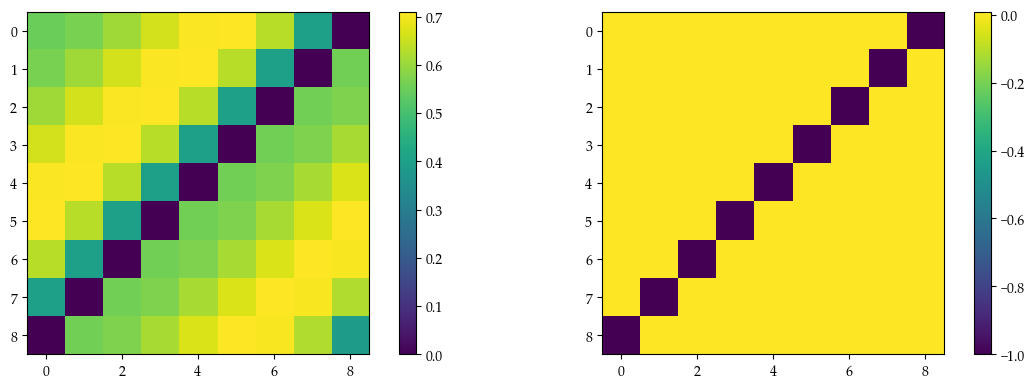

In [4]:
fig, axs = plt.subplots(1,2, figsize=(12,4))

ax = axs[0]
image = ax.imshow([output_data[10,i:i+9,0] for i in range(0,9)])
fig.colorbar(image)

ax = axs[1]
image = ax.imshow([input_data[2][10,i:i+9,0] for i in range(0,9)])
fig.colorbar(image)

fig.tight_layout()

In [5]:
# --- Data flattening and reformatting
flattened_outputs = output_data.reshape((500,81*16))
print(flattened_outputs.shape)

(500, 1296)


In [6]:
print(f"Pre:\t{input_data.shape}") #type:ignore
flattened_inputs = input_data.reshape(500, 81*16*7) #type:ignore
print(f"Post:\t{flattened_inputs.shape}") #type:ignore

Pre:	(7, 500, 81, 16)
Post:	(500, 9072)


#### [3] Forward PCA

Text(0.5, 0, 'Number of Principle Components')

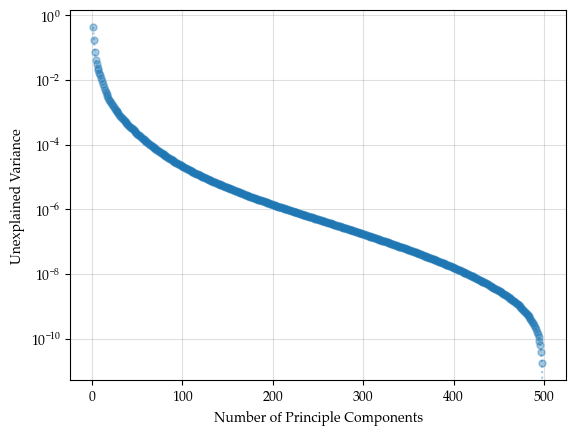

In [7]:
# --- Peform PCA
pcs = [i for i in range(1,501)]

PCA_ALL = PCA(n_components=500, copy=True)
power_pca = PCA_ALL.fit(flattened_outputs)
cumulative_variance = [1-np.sum(power_pca.explained_variance_ratio_[:i]) for i in range(1,501)]

fig,ax = plt.subplots(1,1)
ax.plot(pcs, cumulative_variance, marker='o', markersize=5, ls=':', color='tab:blue', alpha=0.4)
ax.set_yscale('log'); ax.grid(visible=True, which='both', color='gray', alpha=0.25)
ax.set_ylabel("Unexplained Variance"); ax.set_xlabel("Number of Principle Components")

Text(0.5, 0, 'Number of Principle Components')

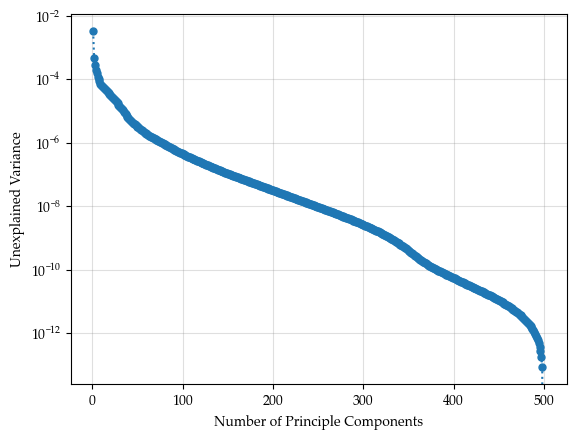

In [9]:
# --- Peform PCA on inputs
pcs = [i for i in range(1,501)]

PCA_ALL = PCA(n_components=500, copy=True)
xs_pca = PCA_ALL.fit(flattened_inputs)
cumulative_xs_variance = [1-np.sum(xs_pca.explained_variance_ratio_[:i]) for i in range(1,501)]

fig,ax = plt.subplots(1,1)
ax.plot(pcs, cumulative_xs_variance, marker='o', markersize=5, ls=':', color='tab:blue')
ax.set_yscale('log'); ax.grid(visible=True, which='both', color='gray', alpha=0.25)
ax.set_ylabel("Unexplained Variance"); ax.set_xlabel("Number of Principle Components")

In [11]:
PCA_0999 = PCA(n_components=0.999, copy=True)
power_0999 = PCA_0999.fit(flattened_outputs)
pca_scores = power_0999.transform(flattened_outputs)
print(pca_scores.shape)

(500, 29)


#### [4] Backward PCA

In [12]:
# --- Invert PCA
recovered_data = power_0999.inverse_transform(pca_scores).reshape(500,81,16)


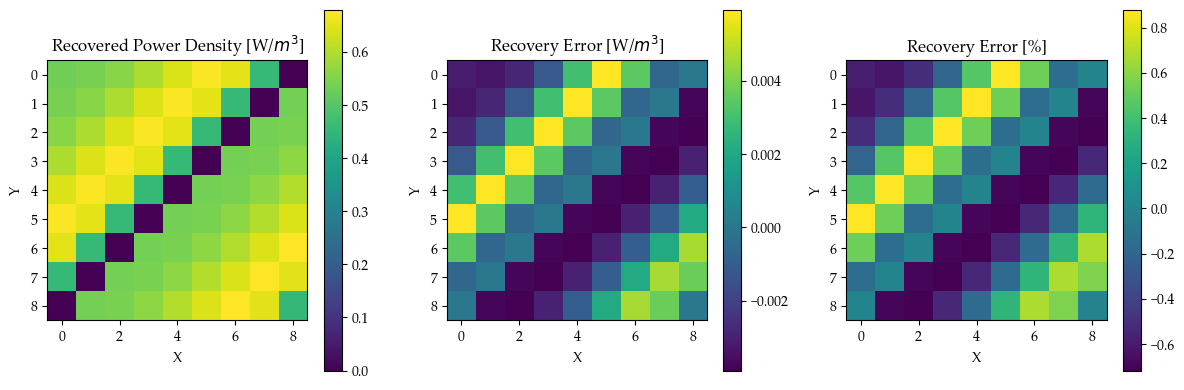

In [13]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

ijk = 42

ax = axs[0]
image = ax.imshow([recovered_data[ijk,i:i+9,0] for i in range(0,9)])
fig.colorbar(image)
ax.set_ylabel("Y"); ax.set_xlabel("X"); ax.set_title("Recovered Power Density [W/$m^3$]")

ax = axs[1]
diff = np.subtract([recovered_data[ijk,i:i+9,0] for i in range(0,9)], [output_data[ijk,i:i+9,0] for i in range(0,9)])
image = ax.imshow(diff)
fig.colorbar(image)
ax.set_ylabel("Y"); ax.set_xlabel("X"); ax.set_title("Recovery Error [W/$m^3$]")

ax = axs[2]
rel_diff = np.divide(diff, [recovered_data[ijk,i:i+9,0] for i in range(0,9)])*100 - np.flip(np.identity(9), 0)*100
image = ax.imshow(rel_diff)
fig.colorbar(image)
ax.set_ylabel("Y"); ax.set_xlabel("X"); ax.set_title("Recovery Error [%]")

fig.tight_layout()

#### [5] PCA Error Analysis

In [1]:
# --- Examine Error in values caused by PCA of outputs